In [21]:
# --- libs
from PIL import Image
from easydict import EasyDict
import os
import json
from PIL import Image
import numpy as np 
Image.MAX_IMAGE_PIXELS = 933120000

from patchify import patchify,unpatchify
import matplotlib.pyplot as plt

args = EasyDict()

In [22]:
args.img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/04.Image_Processing/AO_Data/C1_20230111015112_10034_00006119_L1G_PS_RGB.png"
root_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/04.Image_Processing/AO_Data"
out_file = args.img_path.split("/")[-1].replace(".png","_Pad_out.png")
out_path = os.path.join(root_path, out_file)

args.out_path = out_path

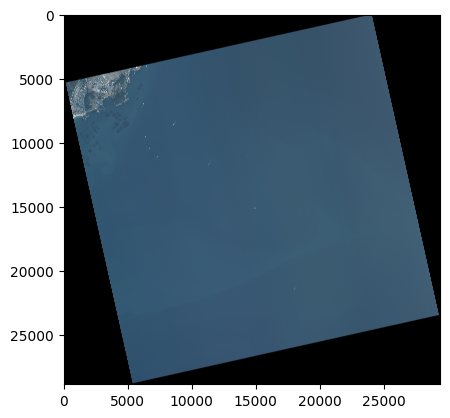

In [23]:
sample_img =  Image.open(args.img_path)
plt.imshow(sample_img)


# Single-Run 

In [24]:
sample_img = np.asarray(sample_img) 

# splitting the image into patches
image_height, image_width, channel_count = sample_img.shape

common_param = 100
patch_height, patch_width, step = common_param,common_param, common_param
patch_shape = (patch_height, patch_width, channel_count)

patches = patchify(sample_img, (patch_height,patch_width,channel_count), step=step)
print(patches.shape)


def process(patch):
    p1 = np.array(patch)
    for i in range(p1.shape[0]):
        for k in range(p1.shape[1]):
            
            #---- filtering
            pixel_ = p1[i][k] 
            if pixel_[0] ==0 and pixel_[1] ==0 and pixel_[2] ==0:
                p1[i][k][3] = 0

    return p1


def measure_patch(patch):
    
    #print(patch.shape)
    p1 = np.array(patch)
    p1_size = (patch.shape[0],patch.shape[1])
    #print(p1_size)
    total = p1_size[0] * p1_size[1]
    black_cnt = 0

    for row in range(p1_size[0]):
        for col in range(p1_size[1]):
            pixel_ = p1[row][col]
            r,g,b = pixel_[0],pixel_[1],pixel_[2] 
            if r==0 and g==0 and b==0:
                black_cnt +=1
    #ratio = black_cnt / total
    
    return black_cnt


#------------------
thres = 10
#-----------------

# processing each patch
output_patches = np.empty(patches.shape).astype(np.uint8)
total_n_pathces = output_patches.shape[0] * output_patches.shape[1]
print("Total # of patches : ", total_n_pathces)
cnt =0 
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i, j, 0] 

        # check the black ratio
        black_count = measure_patch(patch)
        if black_count > thres:
            out_= process(patch)
        else:
            out_= patch 
        output_patches[i, j, 0] = out_

        cnt+=1
        
        progress_ratio = (cnt / total_n_pathces) * 100 
        print(f"Progress : {cnt} out of {total_n_pathces}")
        print(f"Progress : {progress_ratio:.4f} %")


(288, 294, 1, 100, 100, 4)
Total # of patches :  84672
Progress : 1 out of 84672
Progress : 0.0012 %
Progress : 2 out of 84672
Progress : 0.0024 %
Progress : 3 out of 84672
Progress : 0.0035 %
Progress : 4 out of 84672
Progress : 0.0047 %
Progress : 5 out of 84672
Progress : 0.0059 %
Progress : 6 out of 84672
Progress : 0.0071 %
Progress : 7 out of 84672
Progress : 0.0083 %
Progress : 8 out of 84672
Progress : 0.0094 %
Progress : 9 out of 84672
Progress : 0.0106 %
Progress : 10 out of 84672
Progress : 0.0118 %
Progress : 11 out of 84672
Progress : 0.0130 %
Progress : 12 out of 84672
Progress : 0.0142 %
Progress : 13 out of 84672
Progress : 0.0154 %
Progress : 14 out of 84672
Progress : 0.0165 %
Progress : 15 out of 84672
Progress : 0.0177 %
Progress : 16 out of 84672
Progress : 0.0189 %
Progress : 17 out of 84672
Progress : 0.0201 %
Progress : 18 out of 84672
Progress : 0.0213 %
Progress : 19 out of 84672
Progress : 0.0224 %
Progress : 20 out of 84672
Progress : 0.0236 %
Progress : 21 

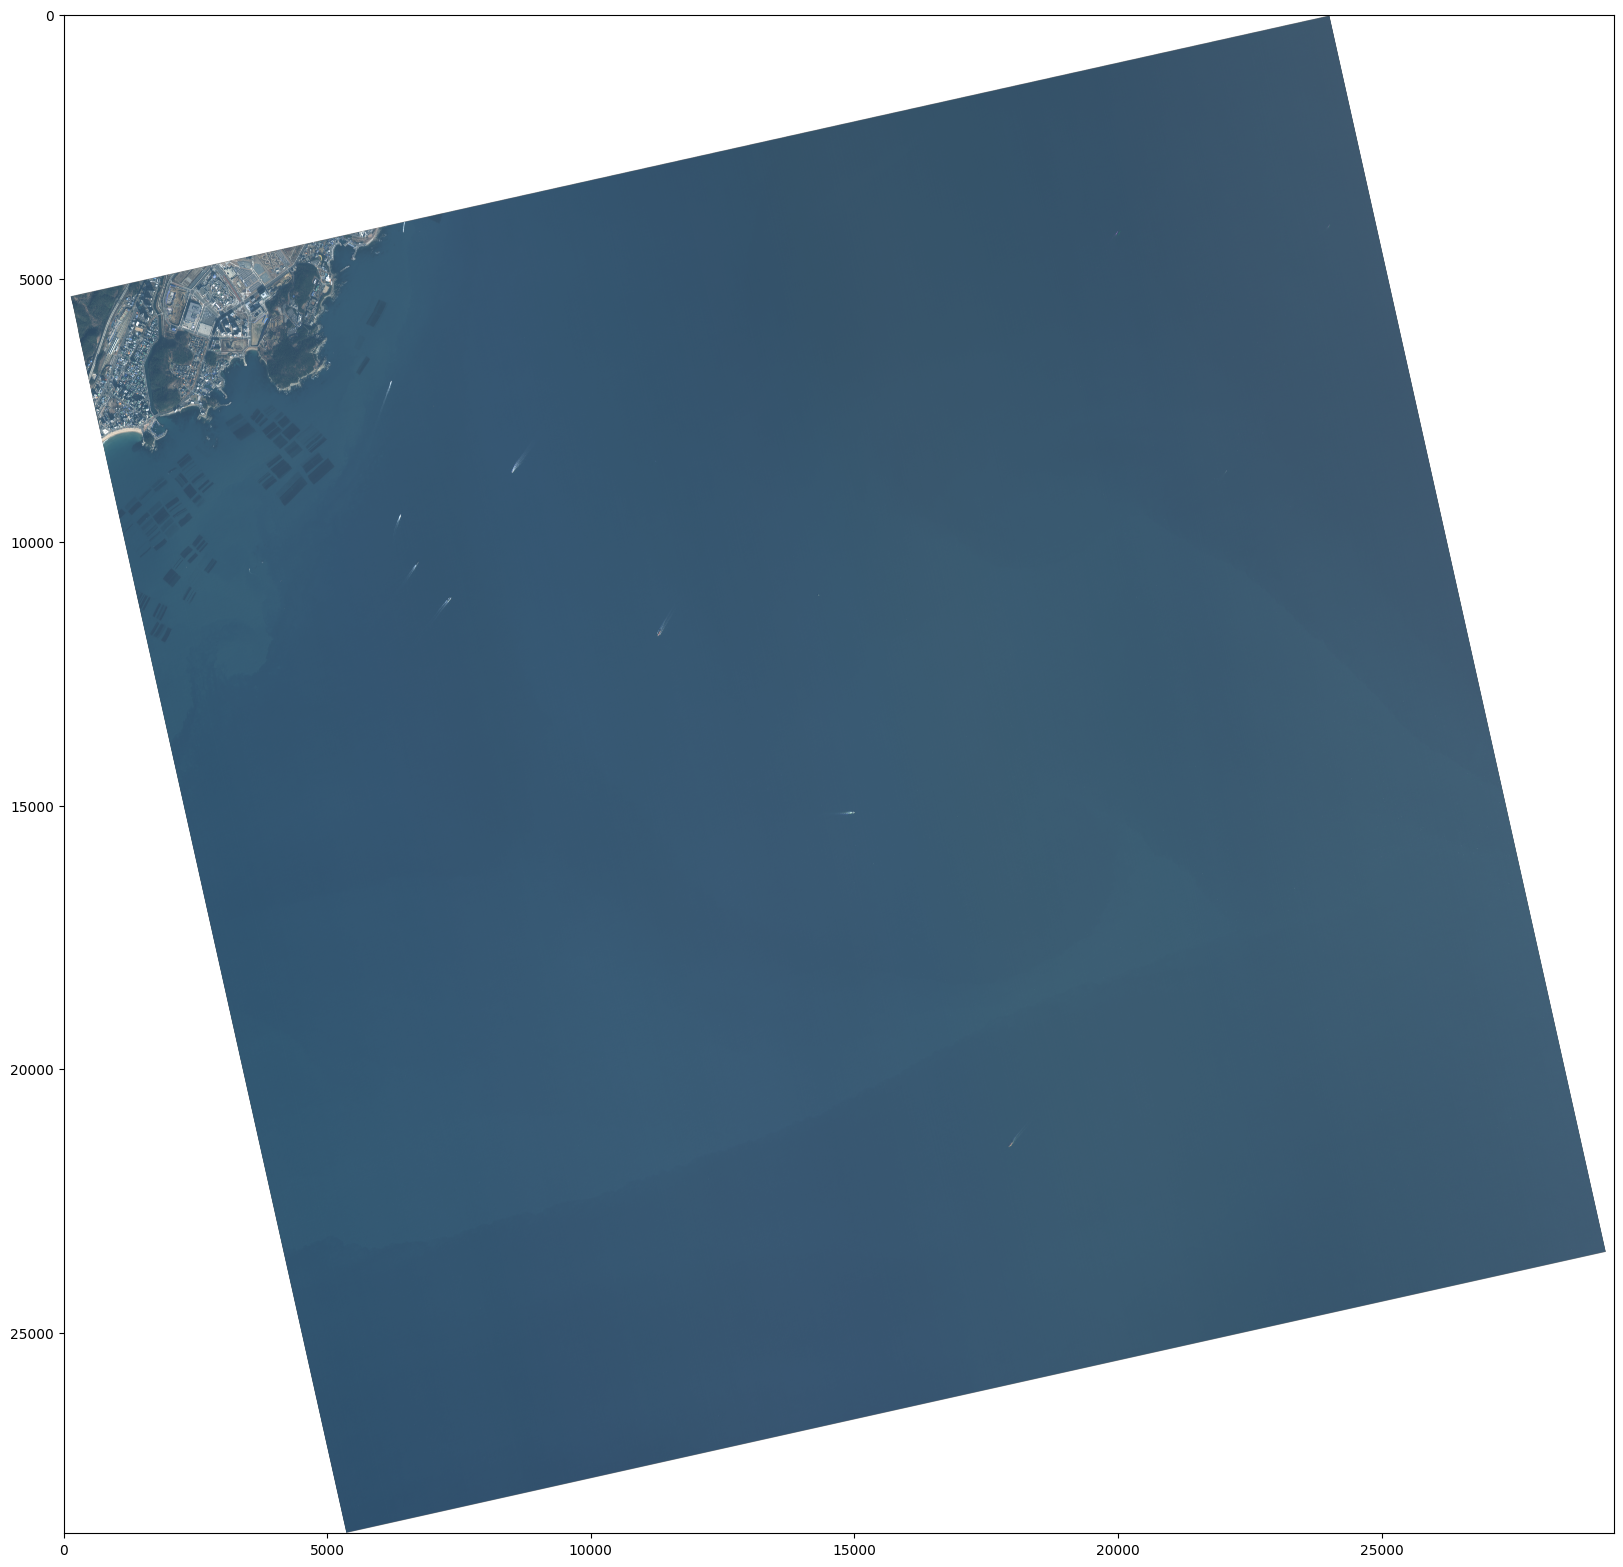

In [25]:
# merging back patches
output_height = image_height - (image_height - patch_height) % step
output_width = image_width - (image_width - patch_width) % step
output_shape = (output_height, output_width, channel_count)
output_image = unpatchify(output_patches, output_shape)
output_image = Image.fromarray(output_image)
output_image.save(args.out_path,compress_level=0)
plt.figure(figsize=(20,20))
plt.imshow(output_image)

# Multi-Processing

In [1]:
import os
from time import sleep

from warnings import warn
from pprint import pprint

from patchify import patchify, unpatchify
import numpy as np
from PIL import Image

from multiprocessing import Pool, cpu_count

MAX_RANGE = 10
COMMON_PARAM = 100

Image.MAX_IMAGE_PIXELS = 933120000
PATCH_HEIGHT, PATCH_WIDTH, STEP = COMMON_PARAM, COMMON_PARAM, COMMON_PARAM


class Convertor:

    def __init__(self, path: str, out_path: str):
        self._path = path
        self._out_path = out_path

    def single_convert(self, name: str, out_name: str = None):
        self._check_paths_exit()
        self._convert(self._path, self._out_path, name, out_name)

    def multiple_convert(self):
        self._check_paths_exit()
        file_list = [
            (self._path, self._out_path, file, None)
            for file in os.listdir(self._path)
            if file.endswith('.png')
        ]
        pool = Pool(cpu_count())
        pool.starmap(self._convert, file_list)
        pool.close()
        pool.join()

    def _check_paths_exit(self):

        if not os.path.exists(self._path):
            raise NotImplementedError("Image Path not correct!")

        if not os.path.exists(self._out_path):
            os.mkdir(self._out_path)
            warn(f"Out Path not correct, Directory made like as {self._out_path}")

    def _convert(self, path, out_path, name, out_name=None):
        print('Start converting...')
        image = Image.open(os.path.join(path, name))
        image_array = np.asarray(image)
        height, width, channel_count = image_array.shape

        print('Done: make image as array')

        self.patches = patchify(image_array, patch_size=(PATCH_HEIGHT, PATCH_WIDTH, channel_count), step=STEP)
        self.output_patches = np.empty(self.patches.shape).astype(np.uint8)

        patches_list = [
            [i, j, 0]
            for i in range(self.patches.shape[0])
            for j in range(self.patches.shape[1])
        ]
        print(f'i: {self.patches.shape[0]}, j: {self.patches.shape[1]}')
        print('Done: create patches list')

        pool = Pool()
        pool.starmap(self._thread, patches_list)
        pool.close()
        pool.join()

        print('Done: calculate and change image')

        self._save_image(height, width, channel_count, out_name, out_path)

        print('Done: save image')

    def _thread(self, i, j, l):
        print(i, j, l)
        patch = self.patches[i, j, l]
        data, should_change = self._check_should_change(patch)

        self.output_patches[i, j, 0] = self._change(data, should_change)

    @staticmethod
    def _check_should_change(patch):
        p1 = np.array(patch)
        p1_size = (patch.shape[0], patch.shape[1])

        black_cnt = 0

        for row in range(p1_size[0]):
            for column in range(p1_size[1]):
                pixel = p1[row][column]

                r, g, b = pixel[0], pixel[1], pixel[2]

                if r == 0 and g == 0 and b == 0:
                    black_cnt += 1

                    if black_cnt > MAX_RANGE:
                        return p1, True
                    else:
                        return patch, False
        # edit by eric 
        # return patch, False

    @staticmethod
    def _change(data, should_change):
        if not should_change:
            return data

        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                pixel = data[i][j]

                if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
                    data[i][j][3] = 0

        return data

    def _save_image(self, height, width, channel_count, out_name, out_path):
        output_height = height - (height - PATCH_HEIGHT) % STEP
        output_width = width - (width - PATCH_WIDTH) % STEP
        output_shape = (output_height, output_width, channel_count)

        output_image = unpatchify(self.output_patches, output_shape)
        output_image = Image.fromarray(output_image)
        output_image.save(os.path.join(out_path, out_name), compress_level=0)


if __name__ == '__main__':
    """
    Mac OS
    example.png 1분 10초
    example_2.png

    Window
    example.png 1분 1초 -> 근데 이상함...
    example_2.png  
    """

    from datetime import datetime

    convertor = Convertor(path="/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/04.Image_Processing/AO_Data", out_path="/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/04.Image_Processing/AO_Data")

    start = datetime.now()
    convertor.single_convert("0-Pusan-2023-AO_1_C1_20221227015155_09806_00006119_L1G.png", "example_test.png")
    end = datetime.now()

    print(end - start)

Start converting...
Done: make image as array
i: 72, j: 74
Done: create patches list
0 0 0
0 1 0
0 2 0
0 3 0
0 4 0
0 5 0
0 6 0
0 7 0
0 8 0
0 9 0
0 10 0
0 11 0
0 12 0
0 13 0
0 14 0
0 15 0
0 16 0
0 17 0
0 18 0
0 19 0
0 20 0
0 21 0
0 22 0
0 23 0
0 24 0
0 25 0
0 26 0
0 27 0
0 28 0
0 29 0
0 30 0
0 31 0
0 32 0
0 33 0
0 34 0
0 35 0
0 36 0
0 37 0
0 38 0
0 39 0
0 40 0
0 41 0
0 42 0
0 43 0
0 44 0
0 45 0
0 46 0
0 47 0
0 48 0
0 49 0
0 50 0
0 51 0
0 52 0
0 53 0
0 54 0
0 55 0
0 56 0
0 57 0
0 58 0
0 59 0
0 60 0
0 61 0
0 62 0
0 63 0
0 64 0
0 65 0
0 66 0
0 67 0
0 68 0
0 69 0
0 70 0
0 71 0
0 72 0
0 73 0
1 0 0
1 1 0
1 2 0
1 3 0
1 4 0
1 5 0
1 6 0
1 7 0
1 8 0
1 9 0
1 10 0
1 11 0
1 12 0
1 13 0
1 14 0
1 15 0
1 16 0
1 17 0
1 18 0
1 19 0
1 20 0
1 21 0
1 22 0
1 23 0
1 24 0
1 25 0
1 26 0
1 27 0
1 28 0
1 29 0
1 30 0
1 31 0
1 32 0
1 33 0
1 34 0
1 35 0
1 36 0
1 37 0
1 38 0
1 39 0
1 40 0
1 41 0
1 42 0
1 43 0
1 44 0
1 45 0
1 46 0
1 47 0
1 48 0
1 49 0
1 50 0
1 51 0
1 52 0
1 53 0
1 54 0
1 55 0
1 56 0
1 57 0
1 59 0
2 4 

TypeError: cannot unpack non-iterable NoneType object

In [27]:
# def exec_multi(patches):
#     cnt = 0
    
#     for i in range(patches.shape[0]):
#         for j in range(patches.shape[1]):
#             patch = patches[i, j, 0 ]  # modified by eric 

#             # check the black ratio
#             black_count = measure_patch(patch)
#             if black_count > thres:
#                 out_= process(patch)
#             else:
#                 out_= patch 
#             output_patches[i, j, 0] = out_

#             cnt+=1            
#             progress_ratio = (cnt / total_n_pathces) * 100 
#             print(f"Progress : {cnt} out of {total_n_pathces}")
#             print(f"Progress : {progress_ratio:.4f} %")
                

In [28]:
# from skimage.util.shape import view_as_blocks

# patches = view_as_blocks(sample_img, (patch_height, patch_width, channel_count)).squeeze()
# print(patches.shape)

In [29]:
# import multiprocessing

# if __name__ == '__main__':
#     # list of input
#     patches = patches

#     # make process pool
#     pool = multiprocessing.Pool(processes=4)

#     # parallel map 
#     pool.starmap(exec_multi, patches)

#     # pool end 
#     pool.close()
#     pool.join()

In [30]:
# iter_patches.shape[0]